<img src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/HydroSARbanner.jpg" width="100%" />

<br>
<font size="6"> <b>FIER Daily Flood Forecasting Code</b><img style="padding: 7px" src="https://radar.community.uaf.edu/wp-content/uploads/sites/667/2021/03/UAFLogo_A_647.png" width="170" align="right"/></font>

<br>
<font size="4"> <b> Franz J Meyer, University of Alaska Fairbanks</b> <br>
</font>

This notebooks is developing an algorithm to generate daily flood inundation predictions using time series of Sentinel-1 RTC data and GEOGLoWs river runoff forecasts. 
    
The workflow utilizes information available in the fierpy <a href="https://github.com/SERVIR/fierpy">fierpy</a> GitHub repository.
<hr>

# Load Python Libraries

In [21]:
from ipyfilechooser import FileChooser
import rioxarray as rxr
import xarray as xr
import fierpy
import glob
import pandas as pd
from pathlib import Path
from ipyfilechooser import FileChooser
import re
from fier_local import reof as freof
import opensarlab_lib as asfn
from osgeo import gdal, osr

In [22]:
def get_dates(dir_path, prefix):
    dates = []
    pths = list(dir_path.glob(f'{prefix}.tif*'))

    for p in pths:
        date_regex = '\d{8}'
        date = re.search(date_regex, str(p))
        if date:
            dates.append(date.group(0))
    return dates

**Function to grab the centerpoint coordinates of the AOI**

In [23]:
def get_centerpoint_coordinates(tif_file):
    dataset = gdal.Open(str(tif_file))
    
    # Get the geospatial transform
    geotransform = dataset.GetGeoTransform()
    
    # Get the image size
    width = dataset.RasterXSize
    height = dataset.RasterYSize
    
    # Calculate the center pixel coordinates
    center_x = geotransform[0] + (geotransform[1] * width + geotransform[2]) / 2
    center_y = geotransform[3] + (geotransform[4] * height + geotransform[5]) / 2
    
    # Create a spatial reference object for EPSG:4326
    src_srs = osr.SpatialReference()
    src_srs.ImportFromEPSG(4326)
    
    # Create a spatial reference object for the TIF file
    dataset_srs = osr.SpatialReference()
    dataset_srs.ImportFromWkt(dataset.GetProjection())
    
    # Create a coordinate transformation object
    coord_transform = osr.CoordinateTransformation(dataset_srs, src_srs)
    
    # Transform the center point coordinates to EPSG:4326
    lon, lat, _ = coord_transform.TransformPoint(center_x, center_y)
    
    return lat, lon


<hr>

# Read sentinel1 time series imagery

In [26]:
fc = FileChooser('/home/jovyan/notebooks')
display(fc)

FileChooser(path='/home/jovyan/notebooks', filename='', title='', show_hidden=False, select_desc='Select', cha…

**Choose the type of data you want to work with (SAR or Water Mask)**

In [27]:
SAR_WaterMask = asfn.select_parameter(sorted({'SAR', 'Water Mask'}), 'Dataset Type:')
SAR_WaterMask

RadioButtons(description='Dataset Type:', layout=Layout(min_width='800px'), options=('SAR', 'Water Mask'), val…

**Choose the polarization you want to work with (we assume you downloaded the hand, so you should have both VV and VH in your folder)**

In [28]:
polarization_choice = asfn.select_parameter(sorted({'VH', 'VH and VV', 'VV'}), 'Polarizations:')
polarization_choice

RadioButtons(description='Polarizations:', layout=Layout(min_width='800px'), options=('VH', 'VH and VV', 'VV')…

In [29]:
if SAR_WaterMask.value == 'SAR':
    if polarization_choice.value == 'VH and VV':
        prefix = '*'
    else:
        prefix = f'*{polarization_choice.value}'
else:
    if polarization_choice.value == 'VH and VV':
        prefix = '*combined'
    else:
        prefix = f'*{polarization_choice.value}*'




tiff_dir = Path(fc.selected)
tiffs = list(tiff_dir.glob(f'{prefix}.tif*'))

**Grab the dates of the tiffs**

In [30]:
times = get_dates(tiff_dir, prefix)
times.sort()
times = pd.DatetimeIndex(times)
times.name = "time"

In [31]:
print(times)

DatetimeIndex(['2022-04-16', '2022-04-28', '2022-05-10', '2022-05-22',
               '2022-06-03', '2022-06-15', '2022-06-27', '2022-07-09'],
              dtype='datetime64[ns]', name='time', freq=None)


In [32]:
da = xr.concat([rxr.open_rasterio(f) for f in tiffs], dim=times)

# delete the extra data variable 'band'
da = da.sel(band=1, drop=True)

# rename autogenerated x,y as lon,lat 
da = da.rename({'x': 'lon', 'y': 'lat'}).fillna(0)
da

<xarray.DataArray (time: 8, lat: 3492, lon: 4014)>
array([[[0.01205861, 0.02152406, 0.07738181, ..., 0.23864971,
         0.14816065, 0.21908844],
        [0.01178609, 0.01425459, 0.03958218, ..., 0.10165761,
         0.15316258, 0.20192304],
        [0.01270515, 0.01029919, 0.01834084, ..., 0.13222253,
         0.19623342, 0.1875777 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.12974784,
         0.11779685, 0.1112971 ],
        [0.        , 0.        , 0.        , ..., 0.13375187,
         0.11819818, 0.10457455],
        [0.        , 0.        , 0.        , ..., 0.11719333,
         0.11295543, 0.10761011]],

       [[0.05273159, 0.03816655, 0.11623389, ..., 0.21719548,
         0.19748688, 0.18743639],
        [0.0186839 , 0.02411868, 0.07147523, ..., 0.11654317,
         0.1406655 , 0.18687536],
        [0.01314925, 0.01608142, 0.03702701, ..., 0.1155033 ,
         0.12869018, 0.1848712 ],
...
        [0.        , 0.        , 0.        , ..., 0.28688222,
         0.28523606, 0.2857984 ],
        [0.        , 0.        , 0.        , ..., 0.2464613 ,
         0.25450116, 0.24496494],
        [0.        , 0.        , 0.        , ..., 0.21131708,
         0.22719783, 0.23868039]],

       [[0.01667472, 0.02532227, 0.07429755, ..., 0.1304375 ,
         0.15037449, 0.22352272],
        [0.01396887, 0.01885476, 0.06563263, ..., 0.08728052,
         0.18289149, 0.26139304],
        [0.00996861, 0.00899386, 0.01802777, ..., 0.1306278 ,
         0.2740019 , 0.25565115],
        ...,
        [0.        , 0.        , 0.        , ..., 0.13253312,
         0.13284795, 0.14483905],
        [0.        , 0.        , 0.        , ..., 0.12939726,
         0.12650919, 0.12753405],
        [0.        , 0.        , 0.        , ..., 0.12858817,
         0.12311308, 0.12164686]]], dtype=float32)
Coordinates:
  * lon          (lon) float64 1.941e+05 1.941e+05 ... 3.144e+05 3.145e+05
  * lat          (lat) float64 3.039e+06 3.039e+06 ... 2.934e+06 2.934e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2022-04-16 2022-04-28 ... 2022-07-09
Attributes:
    AREA_OR_POINT:     Point
    TIFFTAG_DATETIME:  2023:06:08 19:56:27
    TIFFTAG_SOFTWARE:  Created with GAMMA Software www.gamma-rs.ch data2geoti...
    _FillValue:        0.0
    scale_factor:      1.0
    add_offset:        0.0

<hr>

# Apply rotated eof process

In [33]:
#reof_ds = fierpy.reof(da, n_modes=4) # Not using that one because I can't access fierpy.reof to modify it
reof_ds = freof(da, n_modes = 4)

(8, 4)


<hr>

# Get streamflow data from GeoGLOWS & Select the Days we have Observations

In [34]:
lon,lat = get_centerpoint_coordinates(tiffs[0])
q = fierpy.get_streamflow(lat,lon)
q_sel = fierpy.match_dates(q[0],da.time)

# apply polynomial to different modes to find best stats

In [35]:
fit_test = fierpy.find_fits(reof_ds,q_sel,da)

<Figure size 640x480 with 0 Axes>

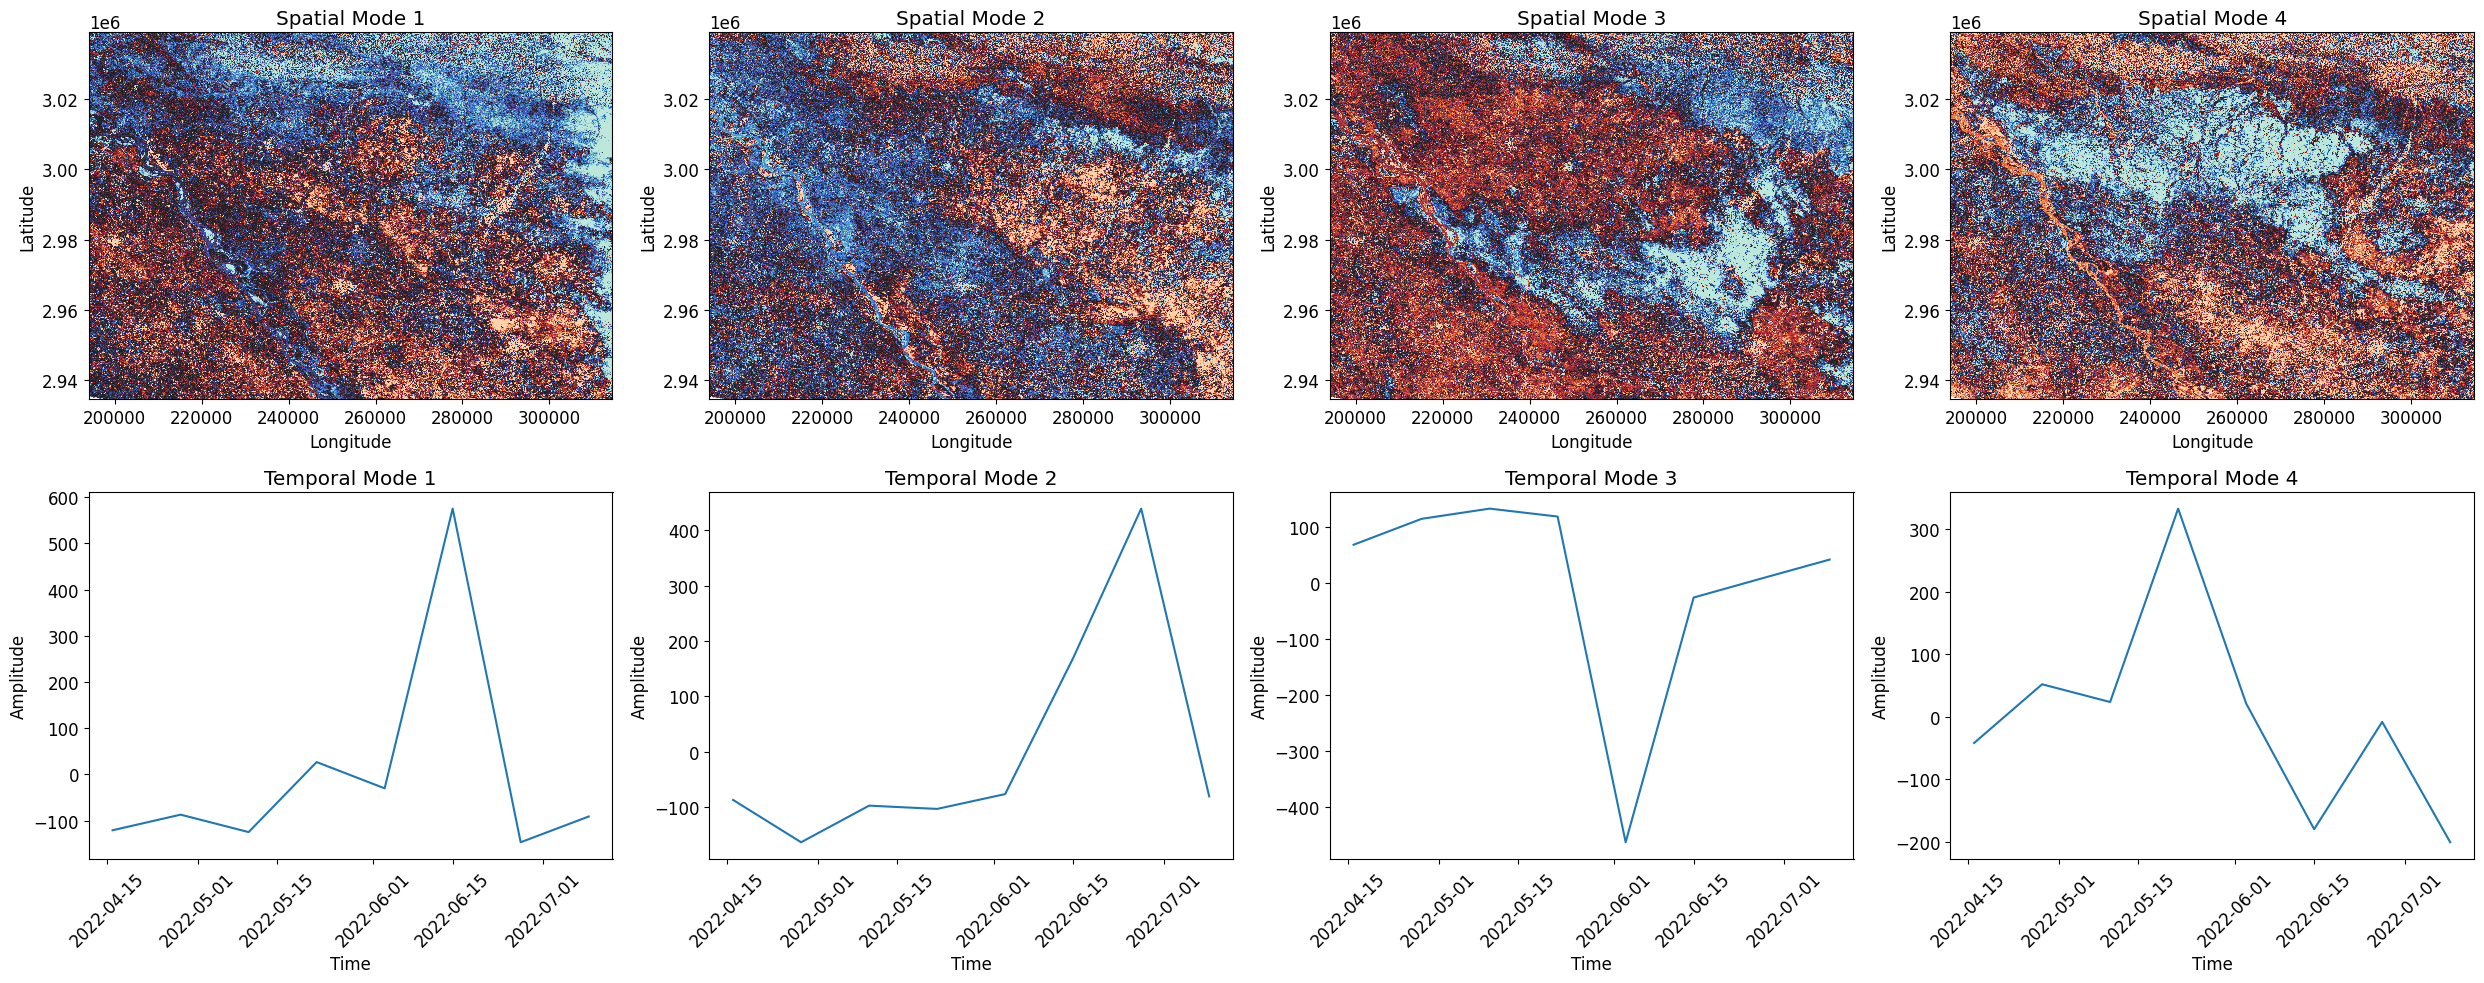

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

reof_ds.spatial_modes.values[reof_ds.spatial_modes.values==0]=np.nan

plt.figure()


fig, axes = plt.subplots(nrows=2, ncols=len(reof_ds.mode.values), figsize=(25, 10))

for i, ax in enumerate(axes[0]):

    # Create a contour plot of the mode
    ax.pcolormesh(reof_ds.lon, reof_ds.lat, reof_ds.spatial_modes.values[:,:,i],
              cmap = 'icefire',
              vmin = -np.nanstd(reof_ds.spatial_modes.values[:,:,i])/2+np.nanmean(reof_ds.spatial_modes.values[:,:,i]),
              vmax = np.nanstd(reof_ds.spatial_modes.values[:,:,i])/2+np.nanmean(reof_ds.spatial_modes.values[:,:,i]))

    # Set plot title and labels
    ax.set_title(f"Spatial Mode {i+1}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

for i, ax in enumerate(axes[1]):
    # Create a line plot of the temporal mode
    ax.plot(times, reof_ds.temporal_modes[:,i])
    # Format x-tick labels as dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.AutoDateLocator())
    # Rotate x-tick labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    # Set plot title and labels
    ax.set_title(f"Temporal Mode {i+1}")
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

plt.savefig(tiff_dir.parent/'Figures'/'SpatiotempModes.png', dpi = 400)
plt.tight_layout()
plt.show()


In [20]:
fit_test

{'mode1_order1_fit_r2': -0.1557654959981558,
 'mode1_order1_pred_r': -999,
 'mode1_order1_pred_rmse': 0.04167492,
 'mode1_order1_coeffs': array([-56.67286103, 308.78371752]),
 'mode1_order2_fit_r2': -72.2981229138277,
 'mode1_order2_pred_r': -999,
 'mode1_order2_pred_rmse': 0.18183106,
 'mode1_order2_coeffs': array([ -21.38074084,  228.18504724, -340.70635095]),
 'mode1_order3_fit_r2': -115355.48644238086,
 'mode1_order3_pred_r': -999,
 'mode1_order3_pred_rmse': 6.8735795,
 'mode1_order3_coeffs': array([  -54.17573577,   870.81987134, -3581.56579217,  4310.20669294]),
 'mode2_order1_fit_r2': -5238.1229135935155,
 'mode2_order1_pred_r': -999,
 'mode2_order1_pred_rmse': 0.06655159,
 'mode2_order1_coeffs': array([-62.90107242, 272.85219785]),
 'mode2_order2_fit_r2': -56605.28283003636,
 'mode2_order2_pred_r': -999,
 'mode2_order2_pred_rmse': 0.17241932,
 'mode2_order2_coeffs': array([ -14.49476707,  130.21426721, -167.46029313]),
 'mode2_order3_fit_r2': -484471537.2491769,
 'mode2_order3_

In [37]:
fit_test

{'mode1_order1_fit_r2': -67.04641699711154,
 'mode1_order1_pred_r': -999,
 'mode1_order1_pred_rmse': 0.04426756,
 'mode1_order1_coeffs': array([2.0406972 , 0.20971758]),
 'mode1_order2_fit_r2': -529.6708449946111,
 'mode1_order2_pred_r': -999,
 'mode1_order2_pred_rmse': 0.067567006,
 'mode1_order2_coeffs': array([  -0.79486884,   54.40476204, -416.23374859]),
 'mode1_order3_fit_r2': -3005.7141102954156,
 'mode1_order3_pred_r': -999,
 'mode1_order3_pred_rmse': 0.12278216,
 'mode1_order3_coeffs': array([-2.13105707e-02,  1.35592446e+00, -2.75257193e+00, -1.37689312e+02]),
 'mode2_order1_fit_r2': -0.0626968372916148,
 'mode2_order1_pred_r': -999,
 'mode2_order1_pred_rmse': 0.041413076,
 'mode2_order1_coeffs': array([  0.25464665, -44.62963464]),
 'mode2_order2_fit_r2': -3.4134272042589773,
 'mode2_order2_pred_r': -999,
 'mode2_order2_pred_rmse': 0.0603236,
 'mode2_order2_coeffs': array([  -0.32298218,   21.53194257, -213.84474219]),
 'mode2_order3_fit_r2': -12.571079634168335,
 'mode2_ord